# corner

In [45]:
import cv2, numpy as np
import math
import time
import random
from matplotlib import pyplot as plt
%matplotlib inline
#import imutils
import qrcode
from pyzbar.pyzbar import decode #QR코드 자동 인식 패키지
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
# 노트북안에서 이미지 업데이트 함수

output_notebook()


def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()
    
    
def create_win(frames, scale=1.0) :    
    global myImage
    
    all = []
    for f in frames :
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    fr=cv2.flip(fr, -1) # because Bokeh flips vertically
    width=fr.shape[1]
    height=fr.shape[0]    

    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=int(width*scale), height=int(height*scale))    
    myImage = p.image_rgba(image=[fr], x=0, y=0, dw=width, dh=height)
    show(p, notebook_handle=True)   
    
    
def update_win(frames) :
    
    all = []
    for f in frames :
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    fr=cv2.flip(fr, -1)
    myImage.data_source.data['image']=[fr]
    push_notebook()
    time.sleep(0.05)

Loading BokehJS ...

## cv2.cornerHarris([1]src, [2]3, [3]3, [4]0.04)
1. 이미지, 
2. block크기. 크게잡으면 크게 잡을 수록 코너일 확률이 낮아진다.       
    - ex) 우리반에서는 내가 영어를 제일 잘할 수 있지만 우리나라에서는 아니다.
3. 소벨크기
4. Harris에만 있는 고유의 값.
    - 0.04 ~ 0.06 정도 값을 준다. 보통 이 정도로 주면 코너점이 결정됨

float32
(600, 868)
-0.005183762
0.010007294


(array([8.70000e+01, 4.70000e+02, 7.58900e+03, 5.10984e+05, 1.43100e+03,
        1.69000e+02, 5.10000e+01, 1.30000e+01, 4.00000e+00, 2.00000e+00]),
 array([-0.00518376, -0.00366466, -0.00214555, -0.00062645,  0.00089266,
         0.00241177,  0.00393087,  0.00544998,  0.00696908,  0.00848819,
         0.01000729], dtype=float32),
 <a list of 10 Patch objects>)

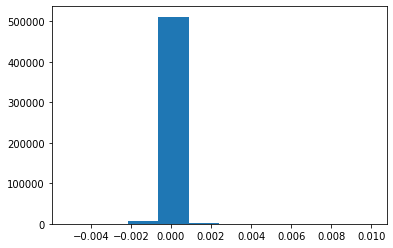

In [9]:
src = cv2.imread('./day6_rs/building.jpg', cv2.IMREAD_GRAYSCALE)

#  block 크기, 소벨크기,    k=0.04~0.06     R=Det() - kTr()
harris = cv2.cornerHarris(src, 3, 3, 0.04)
print(harris.dtype) # float32
print(harris.shape)
print(np.min(harris))  # 코너일 확률을 나타낸것 중 가장 작은 값
print(np.max(harris))  

# 히스토그램을 통해 harris의 분포를 알아보자!
plt.hist(harris.ravel()) # 1차원에서 보는 것(?)

uint8


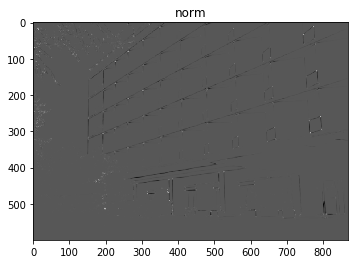

In [14]:
# 최대최소값을 기준으로 정규화
harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
                             # 전체 규모를 0 ~ 255로             # uint8로
print(harris_norm.dtype)
imshow("norm", harris_norm)
# 밝은지점은 다른 것 보다 harris값이 크게 나온 것. 즉, 코너일 확률 높음

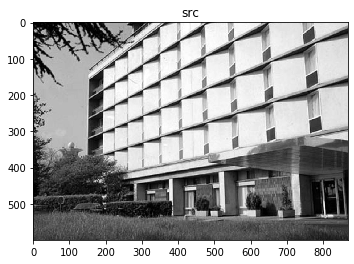

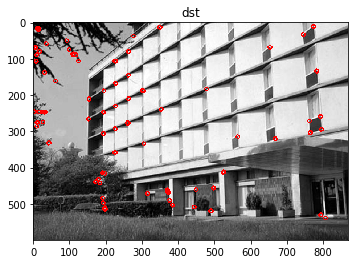

In [15]:
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

# harris_norm은 2차원 행렬
for y in range(harris_norm.shape[0]):   
        for x in range(harris_norm.shape[1]):
            if harris_norm[y, x] > 128:  # 255/2 보다 크면(보통은 중앙값이 합리적인 값...)
                    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2) # 점을찍겠다

imshow('src', src)
imshow('dst', dst)
# 눈으로 봤을때 코너와 기계가 인식하는 코너는 다르다.
# 기계가 인식하는 코너는 모든 방향으로 엣지가 있는 것. 
# 모든(수평,수직 대각선)방향으로의 변화를 검출한다.

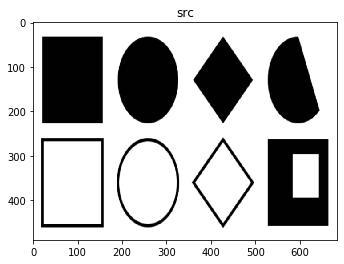

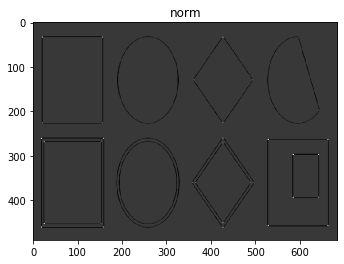

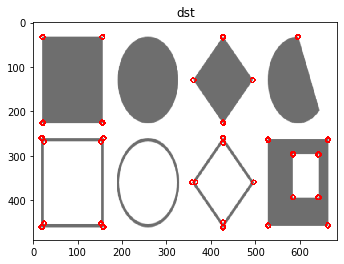

In [17]:
src = cv2.imread('./day6_rs/corner.png', cv2.IMREAD_GRAYSCALE)

harris = cv2.cornerHarris(src, 3, 3, 0.04)

harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)
for y in range(harris_norm.shape[0]):   
        for x in range(harris_norm.shape[1]):
            if harris_norm[y, x] > 90: 
                    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)

imshow('src', src)
imshow("norm", harris_norm)
imshow('dst', dst)

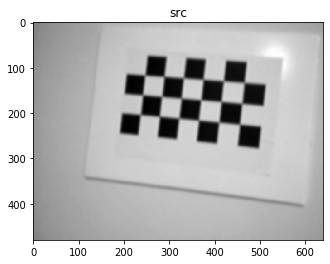

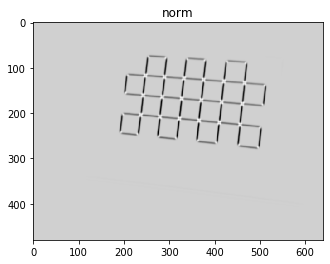

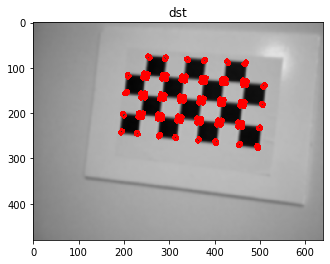

In [28]:
src = cv2.imread('./day6_rs/chessBoard.jpg', cv2.IMREAD_GRAYSCALE)
src = cv2.GaussianBlur(src, (15,15), 0)

harris = cv2.cornerHarris(src, 3, 3, 0.04)

harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

# C는 컴파일러 언어라서 for문을 써도 되지만
# Python은 인터프리터 언어라서 for문을 쓰면 느려져서 쓰면 안된다!
for y in range(harris_norm.shape[0]):   
        for x in range(harris_norm.shape[1]):
            if harris_norm[y, x] > 210: 
                    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)

imshow('src', src)
imshow("norm", harris_norm)
imshow('dst', dst)

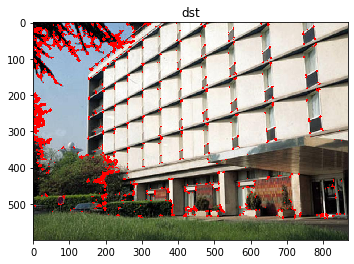

In [34]:
img = cv2.imread('./day6_rs/building.jpg')
gray = cv2.imread('./day6_rs/building.jpg', 0)
dst = cv2.cornerHarris(gray, 5, 3, 0.04)

img[dst > 0.01*dst.max()] = [0,0,255]
imshow('dst',img)

In [31]:
# 위 코드를 간단한 예제로 이해해보기

# numpy의 편리성, 고속성을 느낄 수 있음. 머신러닝에서 넘파이를 사용하는 이유
a = np.array([[1,2,4],[7,0,1]])
print(a)
b = a > 3
print(b)  # True/False값이 나옴
a[b] = 100
print(a)  # True값을 지정값으로 변경

[[1 2 4]
 [7 0 1]]
[[False False  True]
 [ True False False]]
[[  1   2 100]
 [100   0   1]]


In [40]:
# HarrisCorner보다 성능은 떨어지지만 훨씬 빠르다.

#src = cv2.imread('./day6_rs/building.jpg', cv2.IMREAD_GRAYSCALE)
#src = cv2.imread('./day6_rs/corner.png', cv2.IMREAD_GRAYSCALE)
src = cv2.imread('./day6_rs/chessBoard.jpg', cv2.IMREAD_GRAYSCALE)

fast = cv2.FastFeatureDetector_create(50)  # 작아지면 코너 많이 검출됨, 원에서도 검출되지만 중첨되서 검출될수 있음.
keypoints = fast.detect(src)

print(len(keypoints))  # 중첩되어 여러 점이 나온다. => 중첩되지 않도록 처리해줘야함.
                                                # 거리로 따지는건 안좋은 방법임.
print(keypoints[0].pt)
x = keypoints[0].pt[0]
y = keypoints[0].pt[1] # 리턴타입이 튜플

# 튜플타입이므로 이렇게 써도 된다.
x, y = keypoints[0].pt # 0번째 코너의 x, y값



92
(254.0, 75.0)


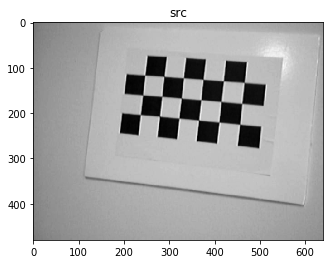

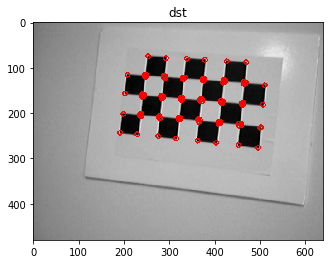

In [41]:
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for kp in keypoints:
        pt = (int(kp.pt[0]), int(kp.pt[1]))
        cv2.circle(dst, pt, 5, (0, 0, 255), 2)

imshow('src', src)
imshow('dst', dst)

(480, 640)


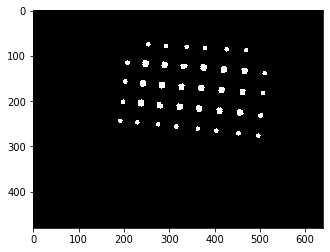

In [43]:
mask = np.zeros(src.shape, dtype = 'uint8')
print(mask.shape)

for kp in keypoints:
    pt = (int(kp.pt[0]), int(kp.pt[1]))
    cv2.circle(mask, pt, 5, (255,255,255), -1)

imshow("",mask) # 각 컨투어의 센터점들만 뽑아내주면 원하는 개수의 코너를 얻을 수 있다.

m00 => 면적. 바이너리 영상에서 면적은, 점의 개수와 같다.
m10 => x축 값을 더한 값

In [ ]:
src = cv2.imread('./day6_rs/chessBoard.jpg')
points = []
for con in contours :
    M = cv2.moments(con, True)
    print(M)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cv2.circle(mask, )

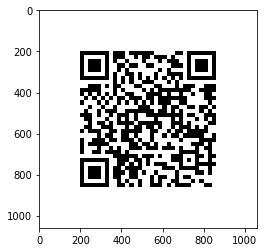

In [44]:
src = cv2.imread('./day6_rs/acronet.png')
gray = cv2.imread('./day6_rs/acronet.png', cv2.IMREAD_GRAYSCALE)

fast = cv2.FastFeatureDetector_create(50) 
keypoints = fast.detect(gray)

for kp in keypoints:
        pt = (int(kp.pt[0]), int(kp.pt[1]))
        cv2.circle(src, pt, 5, (0, 0, 255), 2)

imshow("",src)

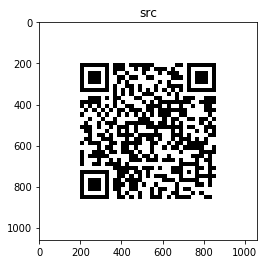

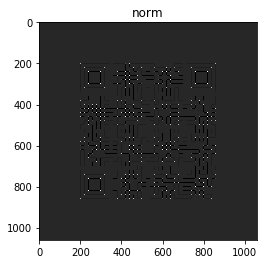

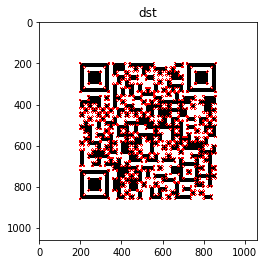

In [46]:
src = cv2.imread('./day6_rs/acronet.png', cv2.IMREAD_GRAYSCALE)

harris = cv2.cornerHarris(src, 3, 3, 0.04)

harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)
for y in range(harris_norm.shape[0]):   
        for x in range(harris_norm.shape[1]):
            if harris_norm[y, x] > 120: 
                    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)

imshow('src', src)
imshow("norm", harris_norm)
imshow('dst', dst)

## QR code 생성하기

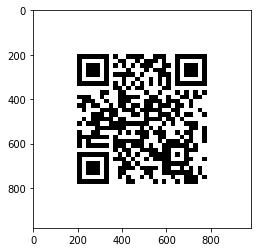

In [7]:
qr = qrcode.QRCode(version = 2,
     error_correction = qrcode.constants.ERROR_CORRECT_H,
     box_size = 20,
     border = 10)

url = 'https://www.naver.com/'
qr.add_data(url)

qr.make()

img = qr.make_image(fill_color="black", back_color="white")

plt.imshow(img, cmap="gray")

img.save("qrcode.png")

## QR Code 해석하기

https://www.naver.com/


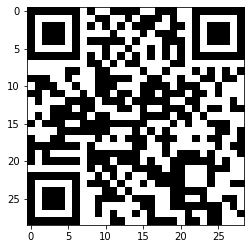

In [22]:
image = cv2.imread("qrcode.png")
image = cv2.GaussianBlur(image, (55,55), 0) # 웬만큼 블러를 줘도 인식함.

qrDecoder = cv2.QRCodeDetector()
data, bbox, rectifiedImage = qrDecoder.detectAndDecode(image)
# return값 
# data, 바운딩박스(좌표값), 

print(data)

imshow("",rectifiedImage)

C028149713739|31176


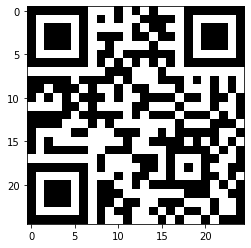

In [10]:
image = cv2.imread("multicampus.jpg")

qrDecoder = cv2.QRCodeDetector()
data, bbox, rectifiedImage = qrDecoder.detectAndDecode(image)

print(data)

imshow("",rectifiedImage)

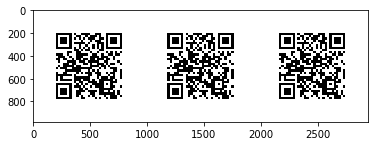

In [4]:
img = cv2.imread("acronet.png")
img = np.hstack([img, img, img])
cv2.imwrite("3.png", img)
imshow("", img)

>1. 코너점 찾기 
2. 디텍션 - QR코드 영역을 찾아줌
3. 디코딩하여 무슨 내용인지 해석

[Decoded(data=b'http://www.acronet.kr/24987', type='QRCODE', rect=Rect(left=201, top=201, width=658, height=658), polygon=[Point(x=201, y=201), Point(x=201, y=859), Point(x=859, y=859), Point(x=859, y=201)])]


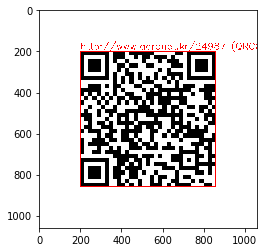

In [10]:
image = cv2.imread('./day6_rs/acronet.png')
#image = cv2.GaussianBlur(image, (51,51), 0)  어디까지 가능한지 테스트
#image = cv2.imread('barqr.jpg')
code = decode(image)
print(code)

for barcode in code:
    (x, y, w, h) = barcode.rect
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
 
    barcodeData = barcode.data.decode("utf-8")
    barcodeType = barcode.type
 
    text = "{} ({})".format(barcodeData, barcodeType)
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
        1.5, (0, 0, 255), 2) 
imshow("", image)

[Decoded(data=b'http://pyimg.co/dl4cv', type='QRCODE', rect=Rect(left=331, top=225, width=103, height=103), polygon=[Point(x=331, y=225), Point(x=331, y=327), Point(x=434, y=328), Point(x=433, y=225)]), Decoded(data=b'https://www.pyimagesearch.com/', type='QRCODE', rect=Rect(left=89, top=66, width=119, height=120), polygon=[Point(x=89, y=66), Point(x=89, y=185), Point(x=208, y=186), Point(x=207, y=66)]), Decoded(data=b'https://openmv.io/', type='QRCODE', rect=Rect(left=441, top=70, width=122, height=122), polygon=[Point(x=441, y=71), Point(x=441, y=191), Point(x=563, y=192), Point(x=562, y=70)]), Decoded(data=b'0100000000020183', type='DATABAR', rect=Rect(left=292, top=786, width=181, height=94), polygon=[Point(x=292, y=787), Point(x=292, y=879), Point(x=473, y=880), Point(x=473, y=786)]), Decoded(data=b'DL4CV', type='CODE39', rect=Rect(left=294, top=632, width=177, height=98), polygon=[Point(x=294, y=633), Point(x=294, y=729), Point(x=471, y=730), Point(x=471, y=632)]), Decoded(data=b

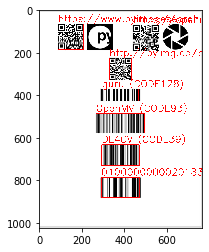

In [11]:
image = cv2.imread('./day6_rs/barqr.jpg')
#image = cv2.GaussianBlur(image, (51,51), 0)  어디까지 가능한지 테스트
#image = cv2.imread('barqr.jpg')
code = decode(image)
print(code)

for barcode in code:
    (x, y, w, h) = barcode.rect
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
 
    barcodeData = barcode.data.decode("utf-8")
    barcodeType = barcode.type
 
    text = "{} ({})".format(barcodeData, barcodeType)
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
        1.5, (0, 0, 255), 2) 
imshow("", image)

- 실제 픽셀 간 매핑시킬때, 주변 값과 비교하여서 찾아야한다.
- 주변 값 없이 특정 픽셀만으로는 같은 데이터인지 확인할 수 없다.
- 스케일이 변하면 주변 값이 사라지거나 변할 수 있어서 이게 과제였다함 ,,
- 각도가 변하는건 회전 계산해서 할 수 있는데 크기변화는 다름

desc1.shape:  (453, 32)
desc2.shape:  (500, 32)


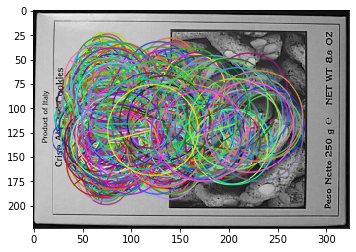

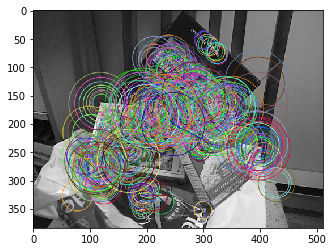

In [46]:
src1 = cv2.imread('./day6_rs/box.png', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('./day6_rs/box_in_scene.png', cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
keypoints1, desc1 = orb.detectAndCompute(src1, None)
keypoints2, desc2 = orb.detectAndCompute(src2, None)

print('desc1.shape: ', desc1.shape)
print('desc2.shape: ', desc2.shape)

dst1 = cv2.drawKeypoints(src1, keypoints1, None, (-1,-1,-1),
                       cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
dst2 = cv2.drawKeypoints(src2, keypoints2, None, (-1,-1,-1),
                       cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

imshow("",dst1)
imshow("",dst2)

In [47]:
# keypoint가 뭔지 desc가 뭔지 이해해야함!

print(keypoints1[171].pt)
print(desc1[171])

print(keypoints2[171].pt)
print(desc2[171])

(56.400001525878906, 134.40000915527344)
[103 153 226  94 193 208  86 176 121  66 254  18 106 254  46 116  93 250
 182 194 221  47 246 227  19  62 144  75 127 173 248  70]
(121.20000457763672, 297.6000061035156)
[169  30  14  49 184 251 145 119 188 239 246 253 159   6 130 153 206  34
 206  52 189 207  97  12 236 195 122 209 202  76 175 217]


In [48]:
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING) # hamming distance는 이진수로 나타낸 거리값
matches = matcher.match(desc1, desc2)

print(len(matches)) # 매칭되는 점의 개수 (양쪽 shape에서 미니멈값)

print(keypoints1[matches[0].queryIdx].pt)
# 첫번째 이미지에서의 매칭 포인트 점의 물리적 좌표
print(keypoints2[matches[0].trainIdx].pt)
# 두번째 이미지에서의 매칭 포인트 점의 물리적 좌표

print(matches[0]) # 첫번째 매칭되는 값의 정보
# <DMatch 000002058E7D4B10>
print(matches[0].queryIdx) # 첫번째 이미지에서의 인덱스
print(matches[0].trainIdx) # 유사하다고 매칭된 두번째 이미지에서의 인덱스
print(matches[0].distance) # 둘 사이의 거리. 엉뚱한 위치끼리 매칭되면 값이 큼

for m in matches :
    print(f"{m.queryIdx - m.trainIdx / m.distance}")


453
(83.0, 78.0)
(343.9854736328125, 186.32545471191406)
<DMatch 000002058E54D7B0>
0
487
86.0
-5.662790697674419
-3.1643835616438354
-2.909090909090909
-0.7471264367816093
2.4634146341463414
0.8701298701298699
5.2073170731707314
5.636363636363637
1.506849315068493
7.7368421052631575
7.987654320987654
4.578947368421052
5.9324324324324325
10.986486486486486
13.75
9.573170731707318
14.588235294117647
13.647887323943662
16.848837209302324
16.614285714285714
16.121951219512194
17.797619047619047
17.243243243243242
16.87142857142857
23.160493827160494
20.595238095238095
25.05263157894737
26.151898734177216
22.28787878787879
25.63855421686747
23.375
25.826666666666668
30.821428571428573
26.430555555555557
30.91025641025641
28.057142857142857
32.0253164556962
31.166666666666668
35.943661971830984
34.7037037037037
37.220588235294116
32.916666666666664
38.45679012345679
35.892307692307696
42.734939759036145
38.43421052631579
42.642857142857146
44.67088607594937
44.951219512195124
48.130434782608

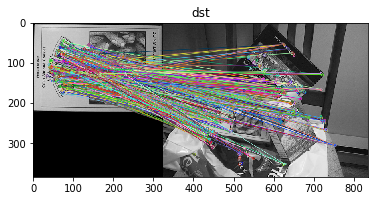

True

In [49]:
dst = cv2.drawMatches(src1, keypoints1, src2, keypoints2, matches, None)

imshow('dst',dst)
cv2.imwrite("orb.png",dst)

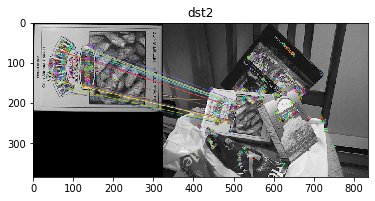

True

In [50]:
matches = sorted(matches, key=lambda x: x.distance) # 오름차순 정렬
good_matches = matches[:20]

dst2 = cv2.drawMatches(src1, keypoints1, src2, keypoints2, good_matches, None)

imshow('dst2',dst2)
cv2.imwrite("orb2.png",dst2)

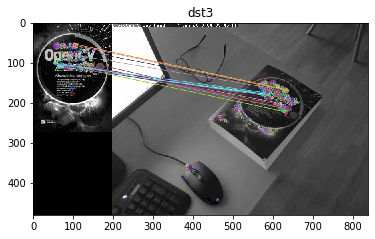

True

In [57]:
src3 = cv2.imread('./day6_rs/book3.jpg', cv2.IMREAD_GRAYSCALE)
src4 = cv2.imread('./day6_rs/book3_1.jpg', cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
keypoints3, desc3 = orb.detectAndCompute(src3, None)
keypoints4, desc4 = orb.detectAndCompute(src4, None)

matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING) 
matches = matcher.match(desc3, desc4)

matches = sorted(matches, key=lambda x: x.distance) # 오름차순 정렬
good_matches = matches[:20]

dst3 = cv2.drawMatches(src3, keypoints3, src4, keypoints4, good_matches, None)

imshow('dst3',dst3)
cv2.imwrite("orb3.png",dst3)

## 파노라마 이미지 만들기(stitching)

In [ ]:
files = ["./day6_rs/img1.jpg", "./day6_rs/img2.jpg", "./day6_rs/img3.jpg"]
imgs = []
for file in files:
    img = cv2.imread(file)
    imgs.append(img)

stitcher = cv2.Stitcher_create()
status, dst = stitcher.stitch(imgs)
cv2.imwrite('result.jpg',dst)
imshow('dst',dst)